In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [14]:
with open("user-wallet-transactions.json", "r") as f:
    data = json.load(f)  # data is already a list of transactions

# Convert to DataFrame
df = pd.DataFrame(data)

# Preview columns
print(df.columns.tolist())
df.head()


['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt']


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [21]:
wallets = df["userWallet"].unique()

features = []

for wallet in tqdm(wallets):
    user_txns = df[df["userWallet"] == wallet]
    
    row = {
        "wallet": wallet,
        "num_txns": len(user_txns),
        "num_deposit": (user_txns["action"] == "deposit").sum(),
        "num_borrow": (user_txns["action"] == "borrow").sum(),
        "num_repay": (user_txns["action"] == "repay").sum(),
        "num_redeem": (user_txns["action"] == "redeemunderlying").sum(),
        "num_liquidation": (user_txns["action"] == "liquidationcall").sum(),
        "total_deposit": user_txns[user_txns["action"] == "deposit"]["actionData"]
            .apply(lambda x: float(x.get("amount", 0))).sum(),
        "total_borrowed": user_txns[user_txns["action"] == "borrow"]["actionData"]
            .apply(lambda x: float(x.get("amount", 0))).sum(),
        "total_repaid": user_txns[user_txns["action"] == "repay"]["actionData"]
            .apply(lambda x: float(x.get("amount", 0))).sum()
    }

    row["repay_ratio"] = (
        row["total_repaid"] / row["total_borrowed"]
        if row["total_borrowed"] > 0 else 0
    )

    features.append(row)

features_df = pd.DataFrame(features)
features_df.head()


100%|██████████████████████████████████████████████████████████████████████████████| 3497/3497 [01:49<00:00, 31.97it/s]


,wallet,num_txns,num_deposit,num_borrow,num_repay,num_redeem,num_liquidation,total_deposit,total_borrowed,total_repaid,repay_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+20,0.000000e+00,0.000000e+00,0.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e+15,0.000000e+00,0.000000e+00,0.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,9.459366e+22,3.946000e+22,7.002457e+10,1.774571e-12


In [22]:
def compute_credit_score(row):
    score = 500  # base score
    
    # Reward positive behavior
    score += row["num_deposit"] * 3
    score += row["repay_ratio"] * 200
    score += row["num_redeem"] * 2

    # Penalize risky behavior
    score -= row["num_liquidation"] * 100
    score -= row["num_borrow"] * 1.5
    
    # Clamp to 0–1000
    return max(0, min(1000, round(score)))

features_df["credit_score"] = features_df.apply(compute_credit_score, axis=1)
features_df.head()


,wallet,num_txns,num_deposit,num_borrow,num_repay,num_redeem,num_liquidation,total_deposit,total_borrowed,total_repaid,repay_ratio,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00,503
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,1.450000e+20,0.000000e+00,0.000000e+00,0.000000e+00,503
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5.000000e+15,0.000000e+00,0.000000e+00,0.000000e+00,506
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,17,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,534
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,130,0,9.459366e+22,3.946000e+22,7.002457e+10,1.774571e-12,1000


In [23]:
features_df.to_csv("wallet_credit_scores.csv", index=False)
print("✅ Saved as wallet_credit_scores.csv")


✅ Saved as wallet_credit_scores.csv


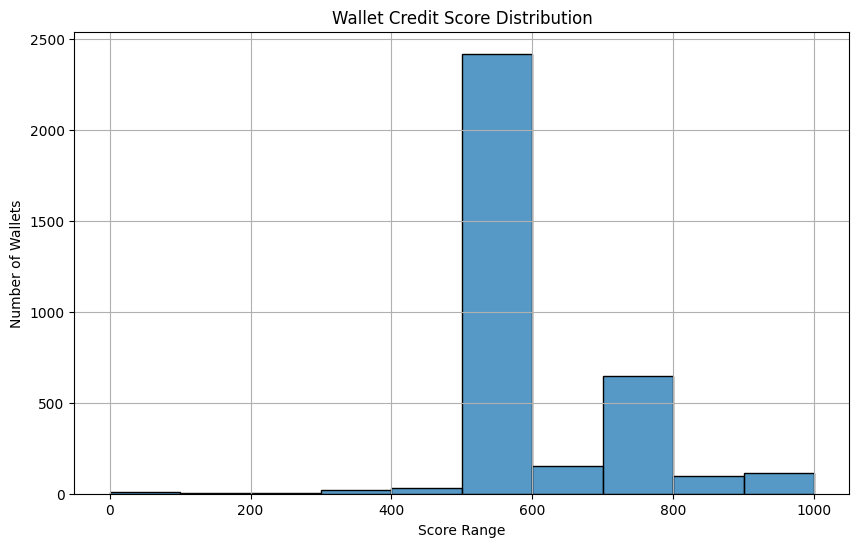

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(features_df["credit_score"], bins=10, kde=False)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.savefig("score_distribution.png")
plt.show()
